# osu! Failtimes Prediction
by Sophie, Emily, and Sine

In this notebook, we retrieved data on 500 beatmaps with a difficulty rating of 1.5 to 2. Then, we created a data frame that split each beatmap into 100 time intervals. Each interval contains summed or averaged data about the hit objects and failtimes/normalized failtimes of the beatmap. We also created a data frame using the partition function, which combined some intervals based on how many hit objects were present.

Using our two data frames, we went onto model training. We tried multiple methods with our easy data frame, such as linear regression, KNN, and 1-D Neural Network. However, none of these really fit our goal well and did not create the model we were looking for. Lastly, we used XGBoost random forrest regression model to train our partition data, which resulted in a good model predicting failtimes for 500 beatmaps.

In [1]:
import sys
sys.path.append('../..')
sys.path.append('../lab')
import pandas as pd
from pymongo import UpdateOne
import numpy as np
from config import client
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab 
from dataset_failtimes import BeatmapSamples

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
import scipy.stats as stats

from preliminary_modeling_failtimes import Xgboost_est_pp_model

In [2]:
from sklearn.metrics import mean_squared_error, r2_score

## Data Retrieval
Preparing data frames for easy beatmaps (difficulty rating between 1.5 and 2).

In [3]:
db = client["osu_mlpp_db1"]
new_beatmaps = list(db.osu_beatmaps.find({"difficultyrating" : {"$gte": 1.5, "$lt": 2}}, 
                                         {"_id" : 1, "mlpp.hit_objects": 1, "mlpp.fail" : 1, 
                                          "difficultyrating" : 1, "playcount": 1, "total_length": 1}).limit(500))

In [4]:
#remove hit_objects = none
for bm in new_beatmaps:
    if bm["mlpp"]["hit_objects"] == None:
        new_beatmaps.remove(bm)
    if bm["mlpp"]["fail"] == None:
        new_beatmaps.remove(bm)

In [5]:
# check the dataframe for hit objects for one of the easiest beatmaps
hit_objects_colnames = ["x","y","x1","y1","repeat_count","duration", "d_time","time"]

new_df = pd.DataFrame(new_beatmaps[0]["mlpp"]["hit_objects"], 
                  columns = hit_objects_colnames)
new_df

,x,y,x1,y1,repeat_count,duration,d_time,time
0,64,320,64,320,1,0,5538,5538
1,64,192,64,192,1,0,697,6235
2,64,64,64,64,1,0,698,6933
3,448,64,448,64,1,0,1395,8328
4,448,192,448,192,1,0,698,9026
...,...,...,...,...,...,...,...,...
78,256,32,256,312,3,697,697,76700
79,64,64,64,64,1,0,2094,79491
80,160,64,440,258,1,1046,698,80189
81,448,160,448,160,1,0,349,81584


## Create Dataframe
In this section, we use a series of functions to create a data frame containing information on 500 beatmaps. Each row represents a time interval in the beatmap, with either summed or averaged traits. Each beatmap is split into 100 intervals. The data frame also contains failtimes per interval, as well as normalized failtimes.

### Easy Data Frame

In [6]:
## for repeat_count, duration, d_time
def CREATE_ARRAY_FOR_MODEL(colname, df):
    col_for_model = []
    for interval in failtimes_rowindex_within_interval:
        col_for_one_interval = -1
        if len(interval) > 0:
            col_for_one_interval = 0
            for i in interval:
                col_for_one_interval += df.iloc[i,][colname]
            ## we take the average for d_time. we take the sum for other columnss
            if (colname == "d_time"):
                col_for_one_interval = col_for_one_interval / len(interval)
        else:
            col_for_one_interval = 0 # NaN
        col_for_model.append(col_for_one_interval)
    return col_for_model

In [7]:
# for coordinates distance (x,y,x1,y1)
def CREATE_COORDINATES_DIST_ARRAY_FOR_MODEL(df):
    col_for_model = []
    for interval in failtimes_rowindex_within_interval:
        col_for_one_interval = -1
        if len(interval) > 0:
            col_for_one_interval = 0
            for i in interval:
                x = df.iloc[i,]["x"]
                y = df.iloc[i,]["y"]
                x1 = df.iloc[i,]["x1"]
                y1 = df.iloc[i,]["y1"]
                col_for_one_interval += np.sqrt((x1 - x) ** 2 + (y1 - y) ** 2)
        else:
            col_for_one_interval = 0 # NaN
        col_for_model.append(col_for_one_interval)
    return col_for_model

In [8]:
# creating the easy data frame
repeat_count_for_model = []
duration_for_model = []
d_time_for_model = []
coord_dist_for_model = []
fail_times_for_model = []
fail_times_for_model_norm = []
time_for_model = []

for i in range(len(new_beatmaps)):

    # saving arrays into a data frame
    df = pd.DataFrame(new_beatmaps[i]["mlpp"]["hit_objects"], 
                  columns = hit_objects_colnames)

    # calculating time interval
    interval = df["time"].iloc[-1]/100
    # creating time array
    time = np.linspace(interval, df["time"].iloc[-1], 100)

    # putting hit objects into timeslot
    failtimes_rowindex_within_interval = []
    lowerBound = 0

    # creating arrays
    for j in np.arange(0, len(time)):
        upperBound = time[j]
        failtimes_rowindex_for_one_interval = []
        for k in np.arange(0, len(df["time"])):
            if df["time"][k] >= lowerBound and df["time"][k] < upperBound:
                failtimes_rowindex_for_one_interval.append(k)
        failtimes_rowindex_within_interval.append(failtimes_rowindex_for_one_interval)
        lowerBound = upperBound

    time_for_model.extend(time)
    fail_times_for_model.extend(new_beatmaps[i]["mlpp"]["fail"])
    fail_times_for_model_norm.extend([failtime/new_beatmaps[i]["playcount"] for failtime in new_beatmaps[i]["mlpp"]["fail"]])
    coord_dist_for_model.extend(CREATE_COORDINATES_DIST_ARRAY_FOR_MODEL(df))
    repeat_count_for_model.extend(CREATE_ARRAY_FOR_MODEL("repeat_count", df))
    duration_for_model.extend(CREATE_ARRAY_FOR_MODEL("duration", df))
    d_time_for_model.extend(CREATE_ARRAY_FOR_MODEL("d_time", df))


In [9]:
easy_df = pd.DataFrame({'time': time_for_model, 'failtimes': fail_times_for_model, 'failtimes_norm': fail_times_for_model_norm, 'coord_dist_sum': coord_dist_for_model, 
                       'repeat_count_sum': repeat_count_for_model, 'duration_sum': duration_for_model, 
                       'd_time_avg': d_time_for_model})
easy_df

,time,failtimes,failtimes_norm,coord_dist_sum,repeat_count_sum,duration_sum,d_time_avg
0,822.82,0,0.000000,0.0,0,0,0.000000
1,1645.64,0,0.000000,0.0,0,0,0.000000
2,2468.46,0,0.000000,0.0,0,0,0.000000
3,3291.28,0,0.000000,0.0,0,0,0.000000
4,4114.10,0,0.000000,0.0,0,0,0.000000
...,...,...,...,...,...,...,...
49995,76861.44,127,0.001172,0.0,0,0,0.000000
49996,77662.08,62,0.000572,0.0,0,0,0.000000
49997,78462.72,125,0.001154,0.0,3,0,322.666667
49998,79263.36,123,0.001135,0.0,3,0,242.000000


### Partition Data Frame
Using partition function to create data frame that combines beatmap intervals information by chunks.

In [10]:
partition = BeatmapSamples.partition(new_beatmaps[0], 2)

In [11]:
partition_df = pd.DataFrame(partition,columns=['num_hit_objects', 'chunks'])
partition_df

,num_hit_objects,chunks
0,2,8
1,3,3
2,2,3
3,3,2
4,2,2
5,3,3
6,2,3
7,2,2
8,2,2
9,2,2


In [12]:
# for all beatmaps
failtimes_norm_array = []
coord_dist_sum_array = []
repeat_count_sum_array = []
duration_sum_array = []
d_time_avg_array = []
partition_all_df = pd.DataFrame()

for j in range(0,500):
    partition_j = BeatmapSamples.partition(new_beatmaps[j], 2)
    partition_j_df = pd.DataFrame(partition_j,columns=['num_hit_objects', 'chunks'])
    
    failtimes_norm_list = list(easy_df.iloc[(j*100):((j+1)*100)]['failtimes_norm'])
    coord_dist_sum_list = list(easy_df.iloc[(j*100):((j+1)*100)]['coord_dist_sum'])
    repeat_count_sum_list = list(easy_df.iloc[(j*100):((j+1)*100)]['repeat_count_sum'])
    duration_sum_list = list(easy_df.iloc[(j*100):((j+1)*100)]['duration_sum'])
    d_time_avg_list = list(easy_df.iloc[(j*100):((j+1)*100)]['d_time_avg'])

    for i in partition_j_df['chunks']:
        failtimes_norm_array.append(sum(failtimes_norm_list[0:i]))
        del failtimes_norm_list[0:i]
        coord_dist_sum_array.append(sum(coord_dist_sum_list[0:i]))
        del coord_dist_sum_list[0:i]
        repeat_count_sum_array.append(sum(repeat_count_sum_list[0:i]))
        del repeat_count_sum_list[0:i]
        duration_sum_array.append(sum(duration_sum_list[0:i]))
        del duration_sum_list[0:i]
        d_time_avg_array.append(sum(d_time_avg_list[0:i]))
        del d_time_avg_list[0:i]
    
    partition_all_df = pd.concat([partition_all_df, partition_j_df])

partition_all_df['failtimes_norm_sum'] = pd.DataFrame(failtimes_norm_array)
partition_all_df['coord_dist_sum_sum'] = pd.DataFrame(coord_dist_sum_array)
partition_all_df['repeat_count_sum_sum'] = pd.DataFrame(repeat_count_sum_array)
partition_all_df['duration_sum_sum'] = pd.DataFrame(duration_sum_array)
partition_all_df['d_time_avg_sum'] = pd.DataFrame(d_time_avg_array)

partition_all_df

,num_hit_objects,chunks,failtimes_norm_sum,coord_dist_sum_sum,repeat_count_sum_sum,duration_sum_sum,d_time_avg_sum
0,2,8,0.000000,0.000000,2,0,6235.0
1,3,3,0.000000,0.000000,3,0,1744.5
2,2,3,0.000000,0.000000,2,0,2093.0
3,3,2,0.000038,0.000000,2,0,1395.0
4,2,2,0.000171,0.000000,3,0,1395.0
...,...,...,...,...,...,...,...
31,3,2,0.002323,0.000000,3,0,1395.0
32,3,3,0.002818,243.706791,3,697,2094.0
33,3,5,0.003914,0.000000,4,0,872.0
34,4,1,0.004885,280.000000,4,697,1046.0


In [13]:
# trial for one beatmap
failtimes_norm_list = list(easy_df.iloc[0:100]['failtimes_norm'])
coord_dist_sum_list = list(easy_df.iloc[0:100]['coord_dist_sum'])
repeat_count_sum_list = list(easy_df.iloc[0:100]['repeat_count_sum'])
duration_sum_list = list(easy_df.iloc[0:100]['duration_sum'])
d_time_avg_list = list(easy_df.iloc[0:100]['d_time_avg'])

failtimes_norm_array = []
coord_dist_sum_array = []
repeat_count_sum_array = []
duration_sum_array = []
d_time_avg_array = []

for i in partition_df['chunks']:
    failtimes_norm_array.append(sum(failtimes_norm_list[0:i]))
    del failtimes_norm_list[0:i]
    coord_dist_sum_array.append(sum(coord_dist_sum_list[0:i]))
    del coord_dist_sum_list[0:i]
    repeat_count_sum_array.append(sum(repeat_count_sum_list[0:i]))
    del repeat_count_sum_list[0:i]
    duration_sum_array.append(sum(duration_sum_list[0:i]))
    del duration_sum_list[0:i]
    d_time_avg_array.append(sum(d_time_avg_list[0:i]))
    del d_time_avg_list[0:i]
    
partition_df['failtimes_norm_sum'] = pd.DataFrame(failtimes_norm_array)
partition_df['coord_dist_sum_sum'] = pd.DataFrame(coord_dist_sum_array)
partition_df['repeat_count_sum_sum'] = pd.DataFrame(repeat_count_sum_array)
partition_df['duration_sum_sum'] = pd.DataFrame(duration_sum_array)
partition_df['d_time_avg_sum'] = pd.DataFrame(d_time_avg_array)
partition_df

,num_hit_objects,chunks,failtimes_norm_sum,coord_dist_sum_sum,repeat_count_sum_sum,duration_sum_sum,d_time_avg_sum
0,2,8,0.000000,0.000000,2,0,6235.0
1,3,3,0.000000,0.000000,3,0,1744.5
2,2,3,0.000000,0.000000,2,0,2093.0
3,3,2,0.000038,0.000000,2,0,1395.0
4,2,2,0.000171,0.000000,3,0,1395.0
5,3,3,0.000152,0.000000,2,0,2093.0
6,2,3,0.000276,244.229400,3,697,1396.0
7,2,2,0.000819,0.000000,2,0,1395.0
8,2,2,0.001543,0.000000,2,0,1046.5
9,2,2,0.005132,0.000000,2,0,698.0


## Model Training

### Linear Regression

Coefficients for linear regression are [-1.27022311e-08 -1.79330680e-06  5.92020340e-04  3.64811148e-07
 -8.54482124e-08] and the intercept is 0.0018609841255108398
mse for linear regression is 0.00029754229510514733
r^2 for linear regression is 0.0028847381932601834


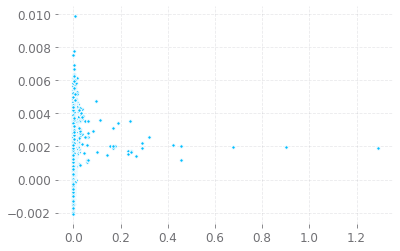

In [14]:
df_for_linearReg = easy_df.dropna()
X = df_for_linearReg[["time", "coord_dist_sum", "repeat_count_sum", "duration_sum", "d_time_avg"]]
y = df_for_linearReg.failtimes_norm
testSize = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize)
 
# train the model
lm = LinearRegression()
lm.fit(X_train, y_train)
 
# return model coefficients
print("Coefficients for linear regression are",lm.coef_, "and the intercept is",lm.intercept_)
 
# plot
y_pred = lm.predict(X_test)
plt.plot(y_test, y_pred, ".")
 
print("mse for linear regression is", mean_squared_error(y_test, y_pred))
print("r^2 for linear regression is",r2_score(y_test, y_pred))
##correlation matrix, residual plot

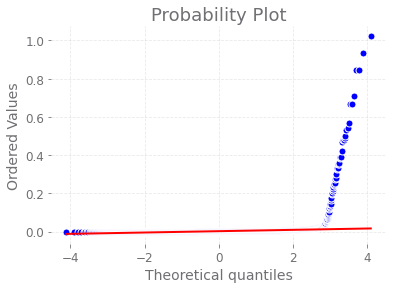

In [15]:
##qq plot
stats.probplot(y_train, dist="norm", plot=pylab)
pylab.show()

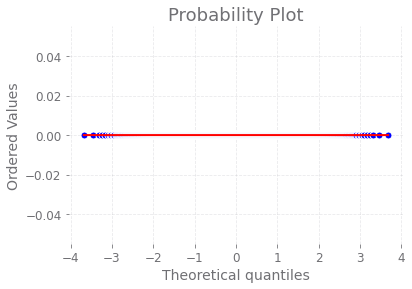

In [16]:
small = np.sort(df_for_linearReg.failtimes_norm)[4000:10000]
stats.probplot(small, dist="norm", plot=pylab)
pylab.show()

In [17]:
## We tried to put y_train into different groups but failed

# from sklearn.neighbors import KNeighborsClassifier
 
# # train the model
# knn = KNeighborsClassifier(n_neighbors=2)
# knn.fit(X_train, y_train)
 
# # test the model
# prediction = knn.predict([[X_train, y_train]])
 
# # how did we do?
# knn.score(X_train, y_train)
 
# from sklearn.metrics import confusion_matrix
 
# confusion_matrix(y_train, knn.predict(X_train))

In [18]:
# from sklearn.naive_bayes import GaussianNB
# from sklearn.model_selection import train_test_split
 
# # X = 
# # y = df.target
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 'a percentage input')
 

# # train the model
# nb = GaussianNB()
# nb.fit(X_train, np.asarray(y_train, dtype="|S6"))

# # test the model
# y_predicted = nb.predict(X_test)
 
# # the underlying list of probabilities
# print(np.round(nb.predict_proba(X_test),3))
# plt.plot(y_test, y_predicted, ".")

In [19]:
# from sklearn import preprocessing
# from sklearn.cluster import KMeans
 
# scaler = preprocessing.StandardScaler()
# X_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
 
# # fit the model
# model = KMeans(n_clusters=2)
# model.fit(X_scaled)
 
# # predict the results
# results = model.predict(X_scaled)

# model.labels_
# # plot the predicted results
# for i in range(1):
#     mask = (results == i)
#     plt.scatter(X.loc[mask, 'var1'], X.loc[mask, 'var2'], label=i)
# plt.xlabel('var1')
# plt.ylabel('var2')
# plt.legend(title="Cluster")
 
# # plot the actual data & compare
# for i in range(3):
#     mask = (df.target == i)
#     plt.scatter(X.loc[mask, 'var1'], X.loc[mask, 'var2'], label=df.target_names[i])
# plt.xlabel('var1')
# plt.ylabel('var2')
# plt.legend(title="Actual Variable")

Conclusion: diagnostics are not great, maybe not linear regression. Let's try something else!

### KNN
##### Probably not the model to use because we have more than 2 predictors

In [21]:
df_for_linearReg = easy_df.dropna()
X = df_for_linearReg[["time", "coord_dist_sum", "repeat_count_sum", "duration_sum", "d_time_avg"]]
y = df_for_linearReg.failtimes_norm
testSize = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize)
 
# train the model
knr = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors = 5))
knr.fit(X_train, y_train)
 
# how did we do?
knr.score(X_test, y_test)

-0.20208295698850876

### 1-D Neural Network
Also not the best choice, since we have multiple predictors.

In [22]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

ModuleNotFoundError: No module named 'keras'

In [ ]:
# load data
trainX, trainy, testX, testy = load_dataset()

df_for_linearReg = easy5_df.dropna()
X = df_for_linearReg[["time", "coord_dist_sum", "repeat_count_sum", "duration_sum", "d_time_avg"]]
y = df_for_linearReg.failtimes_norm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize)

# repeat experiment
scores = list()
for r in range(repeats):
    score = evaluate_model(trainX, trainy, testX, testy)
    score = score * 100.0
    print('>#%d: %.3f' % (r+1, score))
    scores.append(score)
# summarize results
summarize_results(scores)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

### XGBoost
Using the XGBoost random forest regression model to train our partition data. 

In [23]:
df_for_XGBoost = partition_all_df
X = df_for_XGBoost[["coord_dist_sum_sum", "repeat_count_sum_sum", "duration_sum_sum", "d_time_avg_sum"]]
y = df_for_XGBoost.failtimes_norm_sum

In [24]:
y_pred_point2, y_test_point2, rmse_percent_point2 = Xgboost_est_pp_model().train_test_model(X, y, 0.2)

/home/ec2-user/.local/share/virtualenvs/dsu-mlpp-LeXi4iVD/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [25]:
y_pred_vs_real_df_point2 = pd.DataFrame({"y_pred": y_pred_point2, "y_real": y_test_point2})

<AxesSubplot:>

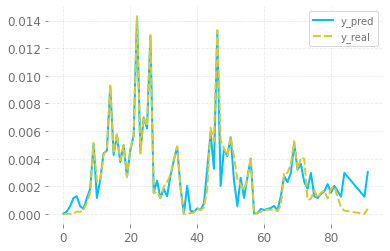

In [26]:
sns.lineplot(data = y_pred_vs_real_df_point2)

## Data Visualization

In [27]:
# bar plot
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.barplot(x = "time", y = "repeat_count_sum", data = new_df)
# plt.figure(figsize=(8,4))
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=7)
g

ValueError: Could not interpret input 'repeat_count_sum'

#### CODES UNUSED

In [ ]:
df2 = pd.DataFrame(beatmap53[0]["mlpp"]["fail"])
df2.describe()

In [ ]:
for one_bm in failtimes:
    bm_id = one_bm["beatmap_id"]
    performance_array = [value for value in one_bm.values()][1:]
    db.osu_beatmap_failtimes.update_one( 
        {"beatmap_id" : bm_id, "type" : "fail"},
        {"$set": {"performance_array" : performance_array}})

In [ ]:
normalizedFailTime = [a/672 for a in beatmap53[0]["mlpp"]["fail"] ]